# Drone Search Path Demo

This notebook lets you experiment with a **search path generator** on a mountain height matrix `H`.

You can replace the example `H` with your own 7×7 / 10×10 / 15×15 matrix.

Main functions:
- `compute_visible_set(H, x0, y0, vis_dist)` – points within visibility distance
- `generate_search_path_greedy(H, vis_dist, safe_margin)` – greedy coverage search path

At the bottom there is a simple visualization using `matplotlib`.

In [9]:
# Imports
import numpy as np
import math
import matplotlib.pyplot as plt

# ==========================================
# 1. Define your mountain matrix H here
# ==========================================
# You can replace this example with your own matrix.
# Example 7x7 matrix with several peaks and valleys:
H = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,2,2,2,2,2,2,0,0,0,0,0,0,0,0],
    [0,2,4,4,4,4,2,2,2,2,2,2,2,2,2],
    [0,2,4,6,6,6,4,2,4,4,4,4,4,4,4],
    [0,2,4,6,8,6,4,2,4,6,6,6,6,6,4],
    [0,2,4,6,6,6,4,2,4,6,8,8,6,6,4],
    [0,2,4,4,4,4,4,2,4,4,6,8,8,6,4],
    [0,2,2,2,2,2,2,2,4,6,8,8,6,4,0],
    [0,2,2,2,2,2,2,2,4,6,6,6,6,4,0],
    [0,2,2,4,4,4,2,2,4,4,4,4,4,4,4],
    [0,2,4,6,4,2,2,2,2,2,2,2,2,2,2],
    [0,0,2,2,2,2,2,0,0,0,0,0,0,0,0],
    [0,2,2,2,2,2,2,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
], dtype=int)

n_rows, n_cols = H.shape
print("Matrix shape:", H.shape)
H

Matrix shape: (15, 15)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 2, 4, 6, 6, 6, 4, 2, 4, 4, 4, 4, 4, 4, 4],
       [0, 2, 4, 6, 8, 6, 4, 2, 4, 6, 6, 6, 6, 6, 4],
       [0, 2, 4, 6, 6, 6, 4, 2, 4, 6, 8, 8, 6, 6, 4],
       [0, 2, 4, 4, 4, 4, 4, 2, 4, 4, 6, 8, 8, 6, 4],
       [0, 2, 2, 2, 2, 2, 2, 2, 4, 6, 8, 8, 6, 4, 0],
       [0, 2, 2, 2, 2, 2, 2, 2, 4, 6, 6, 6, 6, 4, 0],
       [0, 2, 2, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4],
       [0, 2, 4, 6, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [10]:
# ==========================================
# 2. Visibility and greedy search path
# ==========================================
def compute_visible_set(H, x0, y0, vis_dist):
    """Return set of (x,y) indices whose 3D distance to (x0,y0,z0)
    is <= vis_dist. Here z0 = H[x0,y0]. We **ignore terrain occlusion**
    for now and only use distance.
    """
    n_rows, n_cols = H.shape
    z0 = H[x0, y0]
    visible = set()
    for x in range(n_rows):
        for y in range(n_cols):
            z = H[x, y]
            dx = x - x0
            dy = y - y0
            dz = z - z0
            d = math.sqrt(dx*dx + dy*dy + dz*dz)
            if d <= vis_dist:
                visible.add((x, y))
    return visible

def generate_search_path_greedy(H, vis_dist=3.0, safe_margin=1.0):
    """Greedy search path generator.

    U = all surface points (x,y) not yet covered.
    Each step, pick the point that covers the maximum number of
    uncovered points within visibility distance.

    Returns:
        path: list of dicts with keys 'x','y','z'
    """
    n_rows, n_cols = H.shape
    U = {(x, y) for x in range(n_rows) for y in range(n_cols)}
    path = []

    step_idx = 0
    while U:
        best_point = None
        best_cover = set()

        for x in range(n_rows):
            for y in range(n_cols):
                cand_visible = compute_visible_set(H, x, y, vis_dist)
                cover = cand_visible & U
                if len(cover) > len(best_cover):
                    best_cover = cover
                    best_point = (x, y)

        if best_point is None:
            # Should not happen, but just in case
            break

        x_best, y_best = best_point
        z_best = H[x_best, y_best] + safe_margin
        path.append({"x": x_best, "y": y_best, "z": float(z_best)})
        U -= best_cover
        step_idx += 1
        # Debug print
        print(f"Step {step_idx}: choose ({x_best},{y_best}), new uncovered = {len(U)}")

    return path


In [11]:
# ==========================================
# 3. Run the greedy search path on the matrix
# ==========================================
vis_dist = 4.0   # you can adjust this
safe_margin = 1.0

path = generate_search_path_greedy(H, vis_dist=vis_dist, safe_margin=safe_margin)
print("\nFinal path (x,y,z):")
for i, p in enumerate(path):
    print(i, p)


Step 1: choose (6,5), new uncovered = 183
Step 2: choose (11,8), new uncovered = 148
Step 3: choose (5,12), new uncovered = 117
Step 4: choose (11,1), new uncovered = 90
Step 5: choose (2,10), new uncovered = 66
Step 6: choose (3,1), new uncovered = 43
Step 7: choose (10,13), new uncovered = 25
Step 8: choose (0,3), new uncovered = 18
Step 9: choose (9,5), new uncovered = 13
Step 10: choose (11,12), new uncovered = 9
Step 11: choose (0,11), new uncovered = 6
Step 12: choose (3,3), new uncovered = 4
Step 13: choose (11,4), new uncovered = 2
Step 14: choose (3,0), new uncovered = 1
Step 15: choose (4,9), new uncovered = 0

Final path (x,y,z):
0 {'x': 6, 'y': 5, 'z': 5.0}
1 {'x': 11, 'y': 8, 'z': 1.0}
2 {'x': 5, 'y': 12, 'z': 7.0}
3 {'x': 11, 'y': 1, 'z': 1.0}
4 {'x': 2, 'y': 10, 'z': 3.0}
5 {'x': 3, 'y': 1, 'z': 3.0}
6 {'x': 10, 'y': 13, 'z': 3.0}
7 {'x': 0, 'y': 3, 'z': 1.0}
8 {'x': 9, 'y': 5, 'z': 5.0}
9 {'x': 11, 'y': 12, 'z': 1.0}
10 {'x': 0, 'y': 11, 'z': 1.0}
11 {'x': 3, 'y': 3, 'z

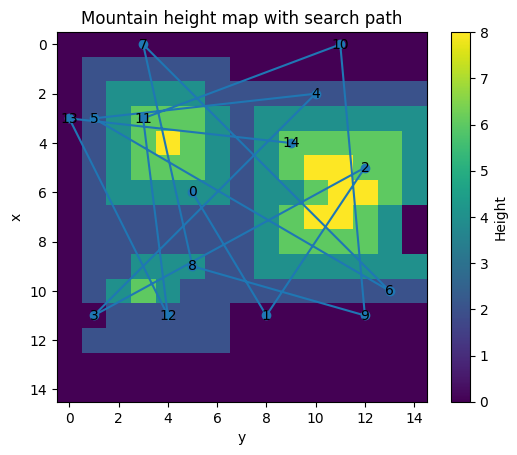

In [12]:
# ==========================================
# 4. Simple visualization
# ==========================================
fig, ax = plt.subplots()
im = ax.imshow(H)
plt.colorbar(im, ax=ax, label="Height")

# Overlay path indices
xs = [p['y'] for p in path]  # note: imshow uses (row=y, col=x) convention visually
ys = [p['x'] for p in path]
ax.plot(xs, ys, marker='o')

for i, (x, y) in enumerate(zip(xs, ys)):
    ax.text(x, y, str(i), ha='center', va='center')

ax.set_title("Mountain height map with search path")
ax.set_xlabel("y")
ax.set_ylabel("x")
plt.show()


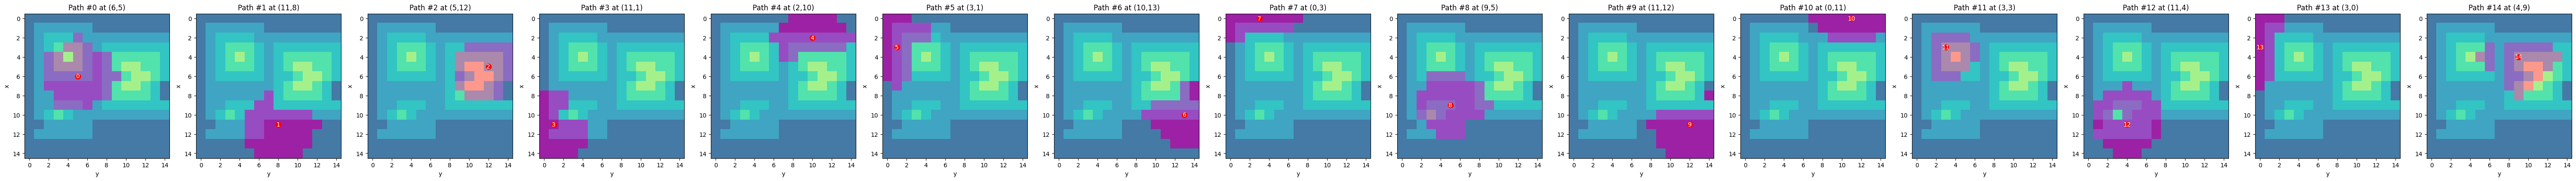

In [13]:
# ==========================================
# 5. Visualize visibility for each path point
# ==========================================
fig, axs = plt.subplots(1, len(path), figsize=(4 * len(path), 4))

if len(path) == 1:
    axs = [axs]

for i, p in enumerate(path):
    x0, y0 = p["x"], p["y"]
    z0 = p["z"]

    # 计算可见点集合
    visible = compute_visible_set(H, x0, y0, vis_dist)

    # 转换为 mask
    mask = np.zeros_like(H, dtype=float)
    for (x, y) in visible:
        mask[x, y] = 1.0

    ax = axs[i]
    ax.set_title(f"Path #{i} at ({x0},{y0})")

    # 绘制高度图
    im = ax.imshow(H, alpha=0.8)

    # 绘制 visibility mask（半透明）
    ax.imshow(mask, alpha=0.35, cmap="cool")

    # 标注观察点
    ax.scatter([y0], [x0], c="red", s=80, marker="o")
    ax.text(y0, x0, f"{i}", color="white", ha="center", va="center")

    ax.set_xlabel("y")
    ax.set_ylabel("x")

plt.tight_layout()
plt.show()

## 6. Accident point + UA/DA/US/DS controls simulation

In this section we add:
- An **accident point** `(ACC_X, ACC_Y)` on the surface
- A simple **drone state** with position `(x,y,z)` and speed
- Functions to simulate the four buttons:
  - `Ua()` – altitude up
  - `Da()` – altitude down
  - `Us()` – speed up
  - `Ds()` – speed down
- A `step_simulation()` function that moves the drone along the generated path.

This mirrors what you will later implement in AVR on the ATmega2560.

In [14]:
# ==========================================
# 6.1 Accident point + visibility check
# ==========================================
ACC_EXISTS = False
ACC_X = None
ACC_Y = None
ACC_Z = None

def set_accident(x, y):
    """Set accident point at grid (x,y) on the surface."""
    global ACC_EXISTS, ACC_X, ACC_Y, ACC_Z
    ACC_EXISTS = True
    ACC_X, ACC_Y = int(x), int(y)
    ACC_Z = float(H[ACC_X, ACC_Y])
    print(f"Accident set at (x={ACC_X}, y={ACC_Y}, z={ACC_Z})")

def clear_accident():
    global ACC_EXISTS, ACC_X, ACC_Y, ACC_Z
    ACC_EXISTS = False
    ACC_X = ACC_Y = ACC_Z = None
    print("Accident cleared")

def is_accident_visible_from(px, py, pz, vis_dist):
    """Return True if accident point is within visibility distance
    from observation point (px,py,pz). Occlusion is ignored here.
    """
    if not ACC_EXISTS:
        return False
    dx = ACC_X - px
    dy = ACC_Y - py
    dz = ACC_Z - pz
    d = math.sqrt(dx*dx + dy*dy + dz*dz)
    return d <= vis_dist


In [15]:
# ==========================================
# 6.2 Drone state + UA/DA/US/DS controls
# ==========================================
drone = {
    'x': None,
    'y': None,
    'z': None,
    'speed': 0,          # cells per simulation step
    'state': 'IDLE',     # IDLE / FLY / FOUND / DONE / CRASH
    'target_index': 0,
    'history': []        # list of (x,y,z)
}

MAX_SPEED = 3
SAFE_MARGIN = 1.0

def reset_drone():
    """Place drone at the first path point and reset state."""
    if not path:
        raise ValueError("Path is empty; generate it first.")
    p0 = path[0]
    drone['x'] = int(p0['x'])
    drone['y'] = int(p0['y'])
    drone['z'] = float(p0['z'])
    drone['speed'] = 1
    drone['state'] = 'FLY'
    drone['target_index'] = 0
    drone['history'] = [(drone['x'], drone['y'], drone['z'])]
    print("Drone reset at", drone)

# ---- button simulations ----
def Ua():
    """Altitude up"""
    drone['z'] += 1
    print("Ua -> z =", drone['z'])

def Da():
    """Altitude down (not below 0)"""
    drone['z'] = max(0, drone['z'] - 1)
    print("Da -> z =", drone['z'])

def Us():
    """Speed up"""
    drone['speed'] = min(MAX_SPEED, drone['speed'] + 1)
    print("Us -> speed =", drone['speed'])

def Ds():
    """Speed down"""
    drone['speed'] = max(0, drone['speed'] - 1)
    print("Ds -> speed =", drone['speed'])

def _move_one_cell_towards_target():
    """Move drone by 1 grid step towards current target point."""
    ti = drone['target_index']
    if ti >= len(path):
        drone['state'] = 'DONE'
        return
    target = path[ti]
    tx, ty = int(target['x']), int(target['y'])
    x, y = drone['x'], drone['y']

    if x < tx:
        x += 1
    elif x > tx:
        x -= 1
    elif y < ty:
        y += 1
    elif y > ty:
        y -= 1

    drone['x'], drone['y'] = x, y
    drone['history'].append((x, y, drone['z']))

    # Collision check with terrain
    surface_z = float(H[x, y])
    if drone['z'] <= surface_z:
        drone['state'] = 'CRASH'
        print("CRASH at", (x, y), "surface_z=", surface_z, "drone_z=", drone['z'])
        return

    # Reached current target?
    if x == tx and y == ty:
        # Check visibility of accident from this observation point
        if is_accident_visible_from(x, y, drone['z'], vis_dist):
            drone['state'] = 'FOUND'
            print("Accident FOUND from (x={}, y={})".format(x, y))
        else:
            drone['target_index'] += 1
            if drone['target_index'] >= len(path):
                drone['state'] = 'DONE'

def step_simulation(steps=1):
    """Advance the simulation by 'steps' time units.
    Each time unit, the drone moves 'speed' grid cells.
    """
    if drone['state'] not in ('FLY', 'IDLE'):
        print("Simulation state =", drone['state'])
        return
    if drone['speed'] == 0:
        print("Speed is 0, drone does not move.")
        return
    for _ in range(steps):
        if drone['state'] != 'FLY':
            break
        for _ in range(drone['speed']):
            if drone['state'] != 'FLY':
                break
            _move_one_cell_towards_target()
    print("After step: ", drone)


Example: set accident, reset drone, adjust UA/US, then step.
Accident set at (x=2, y=1, z=2.0)
Drone reset at {'x': 6, 'y': 5, 'z': 5.0, 'speed': 1, 'state': 'FLY', 'target_index': 0, 'history': [(6, 5, 5.0)]}
Ua -> z = 6.0
Us -> speed = 2
After step:  {'x': 10, 'y': 8, 'z': 6.0, 'speed': 2, 'state': 'FLY', 'target_index': 2, 'history': [(6, 5, 5.0), (6, 5, 6.0), (7, 5, 6.0), (8, 5, 6.0), (9, 5, 6.0), (10, 5, 6.0), (11, 5, 6.0), (11, 6, 6.0), (11, 7, 6.0), (11, 8, 6.0), (10, 8, 6.0)]}


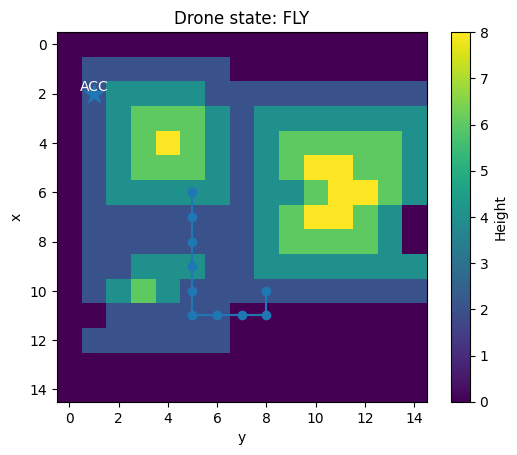

In [16]:
# ==========================================
# 6.3 Visualize drone path + accident point
# ==========================================
def plot_simulation_state():
    fig, ax = plt.subplots()
    im = ax.imshow(H)
    plt.colorbar(im, ax=ax, label="Height")

    if drone['history']:
        xs = [p[1] for p in drone['history']]
        ys = [p[0] for p in drone['history']]
        ax.plot(xs, ys, marker='o')

    if ACC_EXISTS:
        ax.scatter([ACC_Y], [ACC_X], marker='*', s=200)
        ax.text(ACC_Y, ACC_X, 'ACC', color='white', ha='center', va='bottom')

    ax.set_title(f"Drone state: {drone['state']}")
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    plt.show()

# Example usage:
print("Example: set accident, reset drone, adjust UA/US, then step.")
set_accident(2, 1)   # choose any (x,y) you like
reset_drone()
Ua()   # altitude up once
Us()   # speed up once
step_simulation(steps=5)
plot_simulation_state()
